# Прогнозная модель отбора коров и вкуса молока для молочного хозяйства «Вольный луг»

Владелец молочного хозяйства «Вольный луг» хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже.

**Задача:**  
разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
 - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
 - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
 
**С помощью модели нужно отобрать коров по двум критериям:**
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

## Загрузка данных

In [336]:
# базовые библиотеки
import os
import math
import itertools

# научные вычисления и анализ данных
import numpy as np
import pandas as pd
from scipy import stats as st


# визуализация
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import shap

# машинное обучение
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    PowerTransformer,
    StandardScaler,
    MinMaxScaler
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    accuracy_score,
    confusion_matrix,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score
)

from lightgbm import LGBMRegressor

from scipy.stats import chi2_contingency

# пайплайны и трансформеры
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# статистика
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

# константы
RANDOM_STATE = 42

In [337]:
# Определяем пути к локальным файлам
pth_main = '/data/ferma_main.csv'
pth_dad = '/data/ferma_dad.csv'
pth_buy = '/data/cow_buy.csv'

# Определяем URL для альтернативной загрузки
url_main = 'https://code.s3.yandex.net/datasets/ferma_main.csv'
url_dad = 'https://code.s3.yandex.net/datasets/ferma_dad.csv'
url_buy = 'https://code.s3.yandex.net/datasets/cow_buy.csv'

# Функция для загрузки данных
def load_data(local_path, url):
    if os.path.exists(local_path):
        print(f'Загрузка данных из {local_path}...')
        return pd.read_csv(local_path, sep=';')
    else:
        print(f'Файл {local_path} не найден. Загружаем данные из {url}...')
        return pd.read_csv(url, sep=';')

# Загружаем данные
try:
    f_main = load_data(pth_main, url_main)
    f_dad = load_data(pth_dad, url_dad)
    c_buy = load_data(pth_buy, url_buy)

    print('Все данные загружены успешно.')

except Exception as e:
    print(f'Произошла ошибка при загрузке данных: {e}')

Файл /data/ferma_main.csv не найден. Загружаем данные из https://code.s3.yandex.net/datasets/ferma_main.csv...
Файл /data/ferma_dad.csv не найден. Загружаем данные из https://code.s3.yandex.net/datasets/ferma_dad.csv...
Файл /data/cow_buy.csv не найден. Загружаем данные из https://code.s3.yandex.net/datasets/cow_buy.csv...
Все данные загружены успешно.


In [338]:
# Ознакомление с данными
d_lst = [f_main, f_dad, c_buy]

def apply_method(d_lst, method_name, *args, **kwargs):
    for i, df in enumerate(d_lst):
        if hasattr(df, method_name):
            method = getattr(df, method_name)
            if callable(method):
                display(method(*args, **kwargs))
         
         
apply_method(d_lst, 'head')

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


In [339]:
apply_method(d_lst, 'info')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

In [340]:
# Статистические показатели
apply_method(d_lst, 'describe')

,id,"Удой, кг","Сырой протеин, г"
count,634.000000,634.000000,634.000000
mean,317.460568,6187.025237,1922.682965
std,183.096982,1638.401021,182.392548
min,1.000000,5204.000000,1660.000000
25%,159.250000,5751.750000,1772.250000
50%,317.500000,6130.500000,1880.500000
75%,475.750000,6501.000000,2058.750000
max,629.000000,45616.000000,2349.000000


,id
count,629.00000
mean,315.00000
std,181.72094
min,1.00000
25%,158.00000
50%,315.00000
75%,472.00000
max,629.00000


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,4","3,074",более_2_лет
freq,11,11,12,8,3,5,15


В столбце с удоем обнаружена аномалия - 45616 кг. Поскольку это единственное аномальное значение, то в разделе предобработка данных оно будет удалено.

In [341]:
# Поиск полных дубликатов
display(f_main.duplicated().sum())

display(f_dad.duplicated().sum())

display(c_buy.duplicated().sum())

np.int64(5)

np.int64(0)

np.int64(4)

Загруженные данные содержат следующую информацию:  

Файл ferma_main.csv содержит данные о стаде фермера на текущий момент. Описание данных:
- id — уникальный идентификатор коровы.
- Удой, кг — масса молока, которую корова даёт в год (в килограммах).
- ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
- Сырой протеин, г — содержание сырого протеина в корме (в граммах).
- СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
- Порода — порода коровы.
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- порода папы_быка — порода папы коровы.
- Жирность,% — содержание жиров в молоке (в процентах).
- Белок,% — содержание белков в молоке (в процентах).
- Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Предварительно имеется 634 строки и 12 столбцов.    
Столбцы необходимо привести к единому стилю.  
Столбцы "ЭКЕ (Энергетическая кормовая единица)", "СПО (Сахаро-протеиновое соотношение)", "Жирность,%", "Белок,%" имеет тип данных object, далее будет необходимо исправить его на float.  
Пропусков нет. 
Полных дубликатов 5.

Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера. Описание данных:
- id — уникальный идентификатор коровы.
- Имя Папы — имя папы коровы.

Предварительно имеется 629 строк и 2 столбца.    
Столбцы необходимо привести к единому стилю. 
Пропусков нет. 
Полных дубликатов нет.

Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
- Порода — порода коровы.
- Тип пастбища — ландшафт лугов, на которых паслась корова.
- порода папы_быка — порода папы коровы.
- Имя_папы — имя папы коровы.
- Текущая_жирность,% — содержание жиров в молоке (в процентах).
- Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
- Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Предварительно имеется 20 строк и 7 столбцов.    
Столбцы необходимо привести к единому стилю. 
Столбцы "Текущая_жирность,%", "Текущий_уровень_белок,%" имеет тип данных object, далее будет необходимо исправить его на float.
Пропусков нет. 
Полных дубликатов 4.


##  Предобработка данных

In [342]:
# Приведение наименований столбцов к единому стилю с помощью методов lower() и replace()
f_main.columns = f_main.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
display(f_main.columns)

f_dad.columns = f_dad.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
display(f_dad.columns)

c_buy.columns = c_buy.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')
display(c_buy.columns)

# Приведение наименований пастбищ к единому стилю
f_main['тип_пастбища'] = f_main['тип_пастбища'].str.lower()

Index(['id', 'удой_кг', 'эке_(энергетическая_кормовая_единица)',
       'сырой_протеин_г', 'спо_(сахаро-протеиновое_соотношение)', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность_%', 'белок_%',
       'вкус_молока', 'возраст'],
      dtype='object')

Index(['id', 'имя_папы'], dtype='object')

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы',
       'текущая_жирность_%', 'текущий_уровень_белок_%', 'возраст'],
      dtype='object')

In [343]:
# f_main тип данных object, необходимо исправить его на float.  
f_main[["эке_(энергетическая_кормовая_единица)", "спо_(сахаро-протеиновое_соотношение)", "жирность_%", "белок_%"]] = \
f_main[["эке_(энергетическая_кормовая_единица)", "спо_(сахаро-протеиновое_соотношение)",
        "жирность_%", "белок_%"]].apply(lambda x: x.str.replace(',', '.')).astype(float)

# c_buy тип данных object, необходимо исправить его на float.  
c_buy[['текущая_жирность_%', 'текущий_уровень_белок_%']] = \
c_buy[['текущая_жирность_%', 'текущий_уровень_белок_%']].apply(lambda x: x.str.replace(',', '.')).astype(float)

In [344]:
# Удаление полных дубликатов
f_main.drop_duplicates(ignore_index=True, inplace=True)
#c_buy.drop_duplicates(ignore_index=True, inplace=True) # тестовая выборка - строки удалять нельзя

In [345]:
# Удаление неявных дубликатов
display(f_main['порода_папы_быка'].unique())
f_main.loc[f_main['порода_папы_быка'] == 'Айдиалл', 'порода_папы_быка'] = 'Айдиал'
f_main.loc[f_main['порода_папы_быка'] == 'Соверин', 'порода_папы_быка'] = 'РефлешнСоверинг'
c_buy.loc[c_buy['порода_папы_быка'] == 'Соверин', 'порода_папы_быка'] = 'РефлешнСоверинг'
display(f_main['порода_папы_быка'].unique())

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

array(['Айдиал', 'РефлешнСоверинг'], dtype=object)

In [346]:
# Удаление неявных дубликатов
display(f_main['тип_пастбища'].unique())
f_main.loc[f_main['тип_пастбища'] == 'равнинные', 'тип_пастбища'] = 'равнинное'
display(f_main['тип_пастбища'].unique())

array(['равнинное', 'равнинные', 'холмистое'], dtype=object)

array(['равнинное', 'холмистое'], dtype=object)

In [347]:
# Удаление аномальных значений
display(f_main.describe().loc[['max', 'min']])
# обнаружено аномальное максимальное значение
# удаляем аномальное значение
f_main = f_main.drop(f_main[f_main['удой_кг'] > 8000].index)

,id,удой_кг,эке_(энергетическая_кормовая_единица),сырой_протеин_г,спо_(сахаро-протеиновое_соотношение),жирность_%,белок_%
max,629.0,45616.0,16.8,2349.0,0.96,3.75,3.085
min,1.0,5204.0,10.9,1660.0,0.84,2.99,3.069


In [348]:
# Соединение таблиц f_main и f_dad
main = pd.merge(f_main, f_dad, how='inner', left_on='id', right_on='id')
display(f_main.shape, f_dad.shape)
display(main.head(3))
main.shape

(628, 12)

(629, 2)

,id,удой_кг,эке_(энергетическая_кормовая_единица),сырой_протеин_г,спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин


(628, 13)

**Результаты предобработки данных:**  
- полные дубликаты исключены.
- неявные дубликаты исправлены.
- аномальное значение удоев исключено.
- исправлен тип данных в столбцах.
- добавлен столбец с общими продажами по региону.
- таблицы ferma_main.csv и ferma_dad.csv объединены.
 
Данные подготовлены для дальнейшей работы.

## Исследовательский анализ данных

### Анализ распределения целевых переменных в данных о стаде фермера

In [349]:
def plot_histogram(data, column, title, nbins=30):
    """
    Функция для построения гистограммы для количественного признака с выделением среднего и медианного значений.
    
    :param data: DataFrame с данными
    :param column: Название столбца для построения гистограммы
    :param title: Заголовок графика
    :param nbins: Количество бинов для гистограммы
    """
    mean_value = data[column].mean()
    median_value = data[column].median()
    
    fig = go.Figure()
    fig.add_trace(
        go.Histogram(x=data[column], nbinsx=nbins, name=column)
    )
    
    # Добавление вертикальной линии для среднего значения
    fig.add_shape(
        type="line",
        x0=mean_value, y0=0, x1=mean_value, y1=1,
        xref='x', yref='paper',
        line=dict(color="red", width=2, dash="dash"),
        name='Среднее'
    )
    
    # Добавление вертикальной линии для медианного значения
    fig.add_shape(
        type="line",
        x0=median_value, y0=0, x1=median_value, y1=1,
        xref='x', yref='paper',
        line=dict(color="blue", width=2, dash="dot"),
        name='Медиана'
    )
    
    # Обновление макета с добавлением легенды
    fig.update_layout(
        title_text=title,
        xaxis_title=column,
        yaxis_title='Количество',
        showlegend=True
    )
    
    # Добавление аннотаций для среднего и медианного значений
    fig.add_trace(
        go.Scatter(
            x=[mean_value],
            y=[0],
            mode="lines",
            line=dict(color="red", width=2, dash="dash"),
            name="Среднее"
        )
    )
    
    fig.add_trace(
        go.Scatter(
            x=[median_value],
            y=[0],
            mode="lines",
            line=dict(color="blue", width=2, dash="dot"),
            name="Медиана"
        )
    )
    
    fig.show()
    print(data[column].describe())

def plot_bar(data, column, title):
    """
    Функция для построения столбчатой диаграммы для категориального признака.
    
    :param data: DataFrame с данными
    :param column: Название столбца для построения столбчатой диаграммы
    :param title: Заголовок графика
    """
    counts = data[column].value_counts()
    fig = go.Figure()
    fig.add_trace(
        go.Bar(x=counts.index, y=counts.values, name=column)
    )
    fig.update_layout(title_text=title, xaxis_title=column, yaxis_title='Количество')
    fig.show()
    print(data[column].describe())

In [350]:
# Создаем подграфики
fig = make_subplots(rows=1, cols=2, subplot_titles=("Распределение удоя", "Распределение вкуса молока"))

# Гистограмма для удоя
fig.add_trace(
    go.Histogram(x=main['удой_кг'], nbinsx=30, name='Удой'),
    row=1, col=1
)

# Столбчатая диаграмма для вкуса молока
vkus_counts = main['вкус_молока'].value_counts()
fig.add_trace(
    go.Bar(x=vkus_counts.index, y=vkus_counts.values, name='Вкус молока'),
    row=1, col=2
)

# Обновляем макет
fig.update_layout(height=500, width=1000, title_text="Анализ целевых переменных")
fig.update_xaxes(title_text="Удой, кг", row=1, col=1)
fig.update_xaxes(title_text="Вкус молока", row=1, col=2)
fig.update_yaxes(title_text="Количество", row=1, col=1)
fig.update_yaxes(title_text="Количество", row=1, col=2)

# Отображаем график
fig.show()

# Добавим статистику по удою
print("Статистика по удою:")
print(main['удой_кг'].describe())

# Добавим статистику по вкусу молока
print("\nСтатистика по вкусу молока:")
print(main['вкус_молока'].value_counts(normalize=True))

Статистика по удою:
count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: удой_кг, dtype: float64

Статистика по вкусу молока:
вкус_молока
вкусно       0.589172
не вкусно    0.410828
Name: proportion, dtype: float64


In [351]:
# Создаем боксплот для удоя
fig_udoy = go.Figure()

# Добавляем боксплот
fig_udoy.add_trace(
    go.Box(y=main['удой_кг'], name='Удой', boxmean='sd')
)

# Обновляем макет
fig_udoy.update_layout(height=500, width=800, title_text="Боксплот удоя")
fig_udoy.update_yaxes(title_text="Удой, кг")

# Отображаем график
fig_udoy.show()

По количественному признаку "удой" согласно представленным данным можно выделить следующие аспекты:

- распределение близко к нормальному.
- выбросы отсутствуют.
- среднее и медиана близки друг к другу.
- данные имеют равномерную дисперсию.

По категориальному признаку "вкус молока":

- большая часть молока (58,9%) - "вкусно".


### Анализ признаков в данных о стаде фермера

In [352]:
plot_histogram(main, 'эке_(энергетическая_кормовая_единица)', 'Распределение показателя питательности корма коровы')

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: эке_(энергетическая_кормовая_единица), dtype: float64


Показатель "энергетическая_кормовая_единица" имеет один выброс, мультимодальность.  
Средний показатель 14.7. В случае если соблюдаются нормы кормления стельных сухостойных коров, то из этого можно предположить, что средняя корова весит 600 кг и должна показывать средний удой 6500 кг, а это значит что показатели на ферме (6132 кг из графика выше) ниже нормативных.

In [353]:
plot_histogram(main, 'сырой_протеин_г', 'Содержание сырого протеина в корме (в граммах)')

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: сырой_протеин_г, dtype: float64


По графику, который представляет собой распределение содержания сырого протеина в корме, можно сделать следующие выводы:

- Распределение данных указывает на относительную однородность протеина в корме коровы в стаде фермера.
- Выбросы отсутствуют, что говорит о том, что данные распределены относительно равномерно.
- Среднее значение и медиана близки друг к другу, что подтверждает нормальность распределения.

Согласно методике в расчете на 1 ЭКЕ в рационе должно содержаться: сырого протеина от 139 до 152 г. Если брать средние показатели, то получается что в 1 ЭКЕ сейчас 128.4 г протеина или 2185 на 14,7 ЭКЕ - этого недостаточно.

In [354]:
plot_histogram(main, 'спо_(сахаро-протеиновое_соотношение)', 'Сахаро-протеиновое соотношение', nbins=15)

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: спо_(сахаро-протеиновое_соотношение), dtype: float64


Оптимальным сахаропротеиновым соотношением в рационах жвачных животных является 0,8–1,2:1, то есть на каждые 100 г переваримого протеина приходится от 80 до 120 г сахара. C этим показателем все в норме.

In [355]:
plot_histogram(main, 'жирность_%', 'Жирность молока', nbins=40)

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: жирность_%, dtype: float64


3,5 % - это средний показатель домашнего молока, от которого отталкиваются при покупке фасованной продукции, на рассматриваемой ферме 3,6%. Жирность влияет на вкус молока: чем она выше, тем насыщеннее вкус. В нашей выборке наблюдается примерно такое же среднее значение, даже чуть выше. Также можно сказать, что большая часть молока предположительно вкусно по данному показателю.

In [356]:
plot_histogram(main, 'белок_%', 'Содержание белка')

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: белок_%, dtype: float64


В молоке содержится в среднем 3,3 % белков - это средний общемировой показатель, в России от 2,8 %. В нашей выборке - это 3,07 %. Количество белка в молоке – это показатель того, насколько полно корова обеспечена энергией и одновременно уникальная шкала энергетического уровня всего стада. Калорийность кормов в первую очередь влияет на интенсивность «работы» микроорганизмов рубца, отвечающих за синтез протеина.  
Данный показатель можно повысить если привести в норму питание коров.

In [357]:
plot_bar(main, 'порода', 'Порода коровы')

count                628
unique                 2
top       Вис Бик Айдиал
freq                 372
Name: порода, dtype: object


На ферме преобладают коровы породы Вис Бик Айдиал. 

In [358]:
plot_bar(main, 'тип_пастбища', 'Тип пастбища')

count           628
unique            2
top       холмистое
freq            350
Name: тип_пастбища, dtype: object


Холмистых пастбищ больше, чем равнинных. На текущем этапе данная информация не несет практической пользы и будет более подробно рассмотрена в дальнейшем исследовании при моделировании. На этапе исследовательского анализа данных более информативно было бы рассмотреть являются ли пастбища природными или культурными.

In [359]:
plot_bar(main, 'порода_папы_быка', 'Порода папы быка')

count        628
unique         2
top       Айдиал
freq         317
Name: порода_папы_быка, dtype: object


Имеются две породы папы быка: Айдиал и РефлешнСоверинг. Обе в одинаковых долях.

In [360]:
plot_bar(main, 'возраст', 'Возраст коровы')

count             628
unique              2
top       более_2_лет
freq              518
Name: возраст, dtype: object


На ферме преобладают коровы возрастом более 2 лет, т.е. пригодные для использования в производстве.

In [361]:
plot_bar(main, 'имя_папы', 'Кличка папы быка')

count       628
unique        4
top       Барин
freq        240
Name: имя_папы, dtype: object


Наиболее плодовитым быком является бык по кличке "Барин". В дальнейшем рассмотрим взаимосвязь такого высокого показателя и оценки вкуса молока фермером.

### Анализ признаков в данных о стаде «ЭкоФермы»

In [362]:
def compare_features(main, c_buy, feature, c_buy_feature=None):
    """
    Функция для сравнения распределения признака в датафреймах main и c_buy
    """
    fig = make_subplots(rows=1, cols=2, subplot_titles=('main', 'c_buy'))

    if c_buy_feature is None:
        c_buy_feature = feature

    if feature in main.select_dtypes(include=['float64', 'int64']).columns:
        # Для числовых признаков используем гистограммы
        fig.add_trace(go.Histogram(x=main[feature], name='main'), row=1, col=1)
        fig.add_trace(go.Histogram(x=c_buy[c_buy_feature], name='c_buy'), row=1, col=2)
    else:
        # Для категориальных признаков используем столбчатые диаграммы
        main_counts = main[feature].value_counts()
        c_buy_counts = c_buy[c_buy_feature].value_counts()
        
        fig.add_trace(go.Bar(x=main_counts.index, y=main_counts.values, name='main'), row=1, col=1)
        fig.add_trace(go.Bar(x=c_buy_counts.index, y=c_buy_counts.values, name='c_buy'), row=1, col=2)

    fig.update_layout(
        height=400,
        width=1000,
        title_text=f'Сравнение распределения {feature}',
        showlegend=False
    )
    
    fig.update_xaxes(title_text=feature)
    fig.update_yaxes(title_text='Количество')
    
    fig.show()

# Список признаков для сравнения
features_to_compare = [
    'порода', 'возраст', 'тип_пастбища', 'порода_папы_быка', 'имя_папы',
    ('жирность_%', 'текущая_жирность_%'),
    ('белок_%', 'текущий_уровень_белок_%'),
    ]

# Сравнение признаков
for feature in features_to_compare:
    if isinstance(feature, tuple):
        main_feature, c_buy_feature = feature
        compare_features(main, c_buy, main_feature, c_buy_feature)
    elif feature in main.columns and feature in c_buy.columns:
        compare_features(main, c_buy, feature)
    elif feature in main.columns:
        if f'текущий_уровень_{feature}' in c_buy.columns:
            compare_features(main, c_buy, feature, f'текущий_уровень_{feature}')

# Дополнительные признаки из c_buy, которых нет в main
additional_features = [col for col in c_buy.columns if col not in main.columns and col not in [item[1] if isinstance(item, tuple) else item for item in features_to_compare]]

for feature in additional_features:
    fig = make_subplots(rows=1, cols=1, subplot_titles=('c_buy',))
    
    if c_buy[feature].dtype in ['float64', 'int64']:
        fig.add_trace(go.Histogram(x=c_buy[feature], name='c_buy'))
    else:
        counts = c_buy[feature].value_counts()
        fig.add_trace(go.Bar(x=counts.index, y=counts.values, name='c_buy'))
    
    fig.update_layout(
        height=400,
        width=500,
        title_text=f'Распределение {feature} в c_buy',
        showlegend=False
    )
    
    fig.update_xaxes(title_text=feature)
    fig.update_yaxes(title_text='Количество')
    
    fig.show()

Из сравнительных графиков наблюдается, что:  
- в "ЭкоФерме" породы распределены одинаково, у фермера преобладает Вис Бик Айдиал.
- в "ЭкоФерме" более молодые коровы.
- коровы фермеры чаще бывают на холмистых пастбищах.
- в "ЭкоФерме" преобладающая порода папы быка - РефлешнСоверинг.
- в обоих организациях одинаковый список быков. У фермера лидирует "Барин", в "ЭкоФерме" "Буйный".
- у коров "ЭкоФермы" более жирное молоко.
- содержание белка примерно одинаковое. Видимо на обеих фермах у коров недостаточное питание.

**Выводы по исследовательскому анализу данных:**  
 
 По количественному признаку "удой" на ферме "Вольный луг" согласно представленным данным можно выделить следующие аспекты:

- распределение однородно, выброс удален на этапе предобработки данных.
- среднее и медиана близки друг к другу.
- данные имеют равномерную дисперсию.

По категориальному признаку "вкус молока":

- большая часть молока (58,9%) - "вкусно".

Показатель "энергетическая_кормовая_единица" нормально распределен. Имеет один выброс.  
Средний показатель 14.7. В случае если соблюдаются нормы кормления стельных сухостойных коров, то из этого можно предположить, что средняя корова весит 600 кг и должна показывать средний удой 6500 кг, а это значит что показатели на ферме (6132 кг из графика выше) ниже нормативных.

Необходимо получить дополнительные данные по сырому протеину - в каком объеме корма измеряются показатели и за какой период.

Оптимальным сахаропротеиновым соотношением в рационах жвачных животных является 0,8–1,2:1, то есть на каждые 100 г переваримого протеина приходится от 80 до 120 г сахара. C этим показателем все в норме.

3,5 % - это средний показатель домашнего молока, от которого отталкиваются при покупке фасованной продукции, на рассматриваемой ферме 3,6%. Жирность влияет на вкус молока: чем она выше, тем насыщеннее вкус. В нашей выборке наблюдается примерно такое же среднее значение, даже чуть выше. Также можно сказать, что большая часть молока предположительно вкусно по данному показателю.

В молоке содержится в среднем 3,3 % белков - это средний общемировой показатель, в России от 2,8 %. В нашей выборке - это 3,07 %. Количество белка в молоке – это показатель того, насколько полно корова обеспечена энергией и одновременно уникальная шкала энергетического уровня всего стада. Калорийность кормов в первую очередь влияет на интенсивность «работы» микроорганизмов рубца, отвечающих за синтез протеина.  
Данный показатель можно повысить если привести в норму питание коров.

В молоке содержится в среднем 3,3 % белков - это средний общемировой показатель, в России от 2,8 %. В нашей выборке - это 3,07 %. Количество белка в молоке – это показатель того, насколько полно корова обеспечена энергией и одновременно уникальная шкала энергетического уровня всего стада. Калорийность кормов в первую очередь влияет на интенсивность «работы» микроорганизмов рубца, отвечающих за синтез протеина.  
Данный показатель можно повысить если привести в норму питание коров.

На ферме преобладают коровы возрастом более 2 лет, т.е. пригодные для использования в производстве.

Имеются две породы папы быка: Айдиал и РефлешнСоверинг. Обе в одинаковых долях.

Наиболее плодовитым быком является бык по кличке "Барин".

Из сравнительных графиков наблюдается, что:  
- в "ЭкоФерме" породы распределены одинаково, у фермера преобладает Вис Бик Айдиал.
- в "ЭкоФерме" более молодые коровы.
- коровы фермеры чаще бывают на холмистых пастбищах.
- в "ЭкоФерме" преобладающая порода папы быка - РефлешнСоверинг.
- в обоих организациях одинаковый список быков. У фермера лидирует "Барин", в "ЭкоФерме" "Буйный".
- у коров "ЭкоФермы" более жирное молоко.
- содержание белка примерно одинаковое. Видимо на обеих фермах у коров недостаточное питание.

Перед обучением моделей необходимо СПО и Жирность перевести в категориальные признаки

## Корреляционный анализ

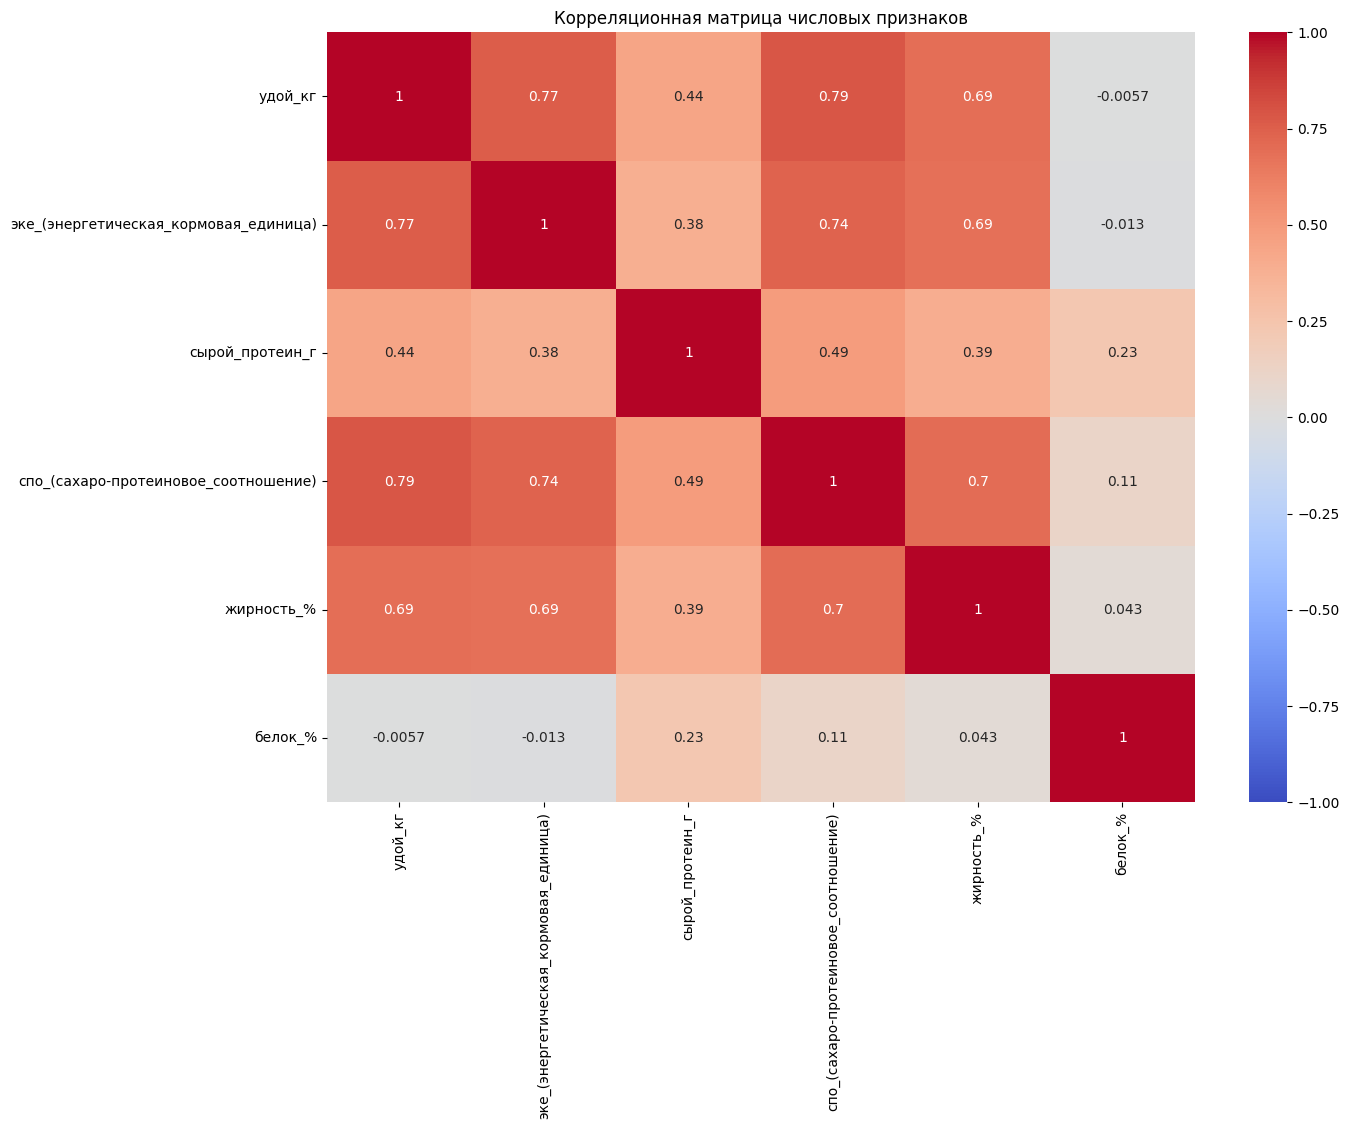

Корреляции с целевой переменной 'удой_кг':
удой_кг                                  1.000000
спо_(сахаро-протеиновое_соотношение)     0.787904
эке_(энергетическая_кормовая_единица)    0.765144
жирность_%                               0.688506
сырой_протеин_г                          0.437543
белок_%                                 -0.005701
Name: удой_кг, dtype: float64


In [363]:
# Выбираем числовые столбцы
numeric_columns = main.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop('id', 1)
# Рассчитываем корреляционную матрицу
correlation_matrix = main[numeric_columns].corr(method='spearman')

# Создаем тепловую карту
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# Выводим корреляции с целевыми переменными
print("Корреляции с целевой переменной 'удой_кг':")
print(correlation_matrix['удой_кг'].sort_values(ascending=False))

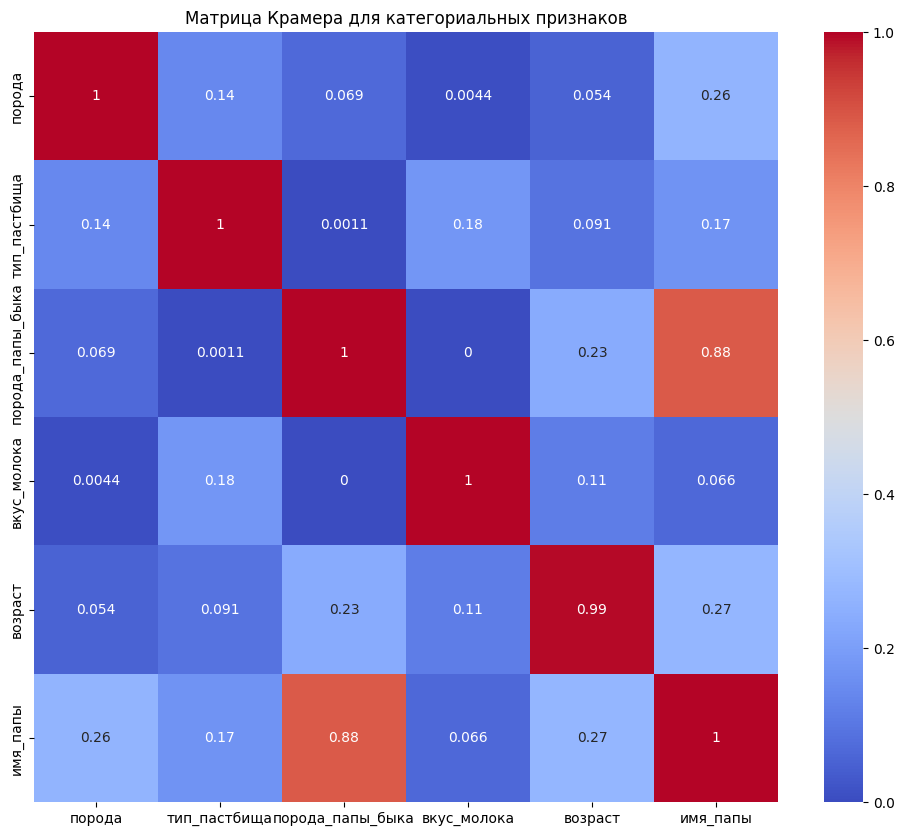


Корреляции категориальных признаков с целевой переменной 'удой_кг':
порода: 0.930
тип_пастбища: 0.900
порода_папы_быка: 0.936
вкус_молока: 0.907
возраст: 0.994
имя_папы: 0.922


In [364]:
# Создаем матрицу Крамера для категориальных признаков
categorical_columns = main.select_dtypes(include=['object']).columns
cramer_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Функция для расчета коэффициента Крамера
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Заполняем матрицу
for i in categorical_columns:
    for j in categorical_columns:
        cramer_matrix.loc[i, j] = cramer_v(main[i], main[j])

# Создаем тепловую карту
plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix.astype(float), annot=True, cmap='coolwarm', vmin=0, vmax=1, center=0.5)
plt.title('Матрица Крамера для категориальных признаков')
plt.show()

# Выводим корреляции с целевой переменной 'удой_кг'
print("\nКорреляции категориальных признаков с целевой переменной 'удой_кг':")
for col in categorical_columns:
    print(f"{col}: {cramer_v(main[col], main['удой_кг']):.3f}")


"Имя папы" сильно коррелирует с "порода папы быка". Удалим для линейной регрессии при подготовке данных.

In [365]:
# Список коррелирующих признаков с целевой переменной 'удой_кг':
quantitative_features = [
    'эке_(энергетическая_кормовая_единица)',
    'сырой_протеин_г',
    'спо_(сахаро-протеиновое_соотношение)',
    'жирность_%',
    'белок_%'
]

<Figure size 1600x1400 with 0 Axes>

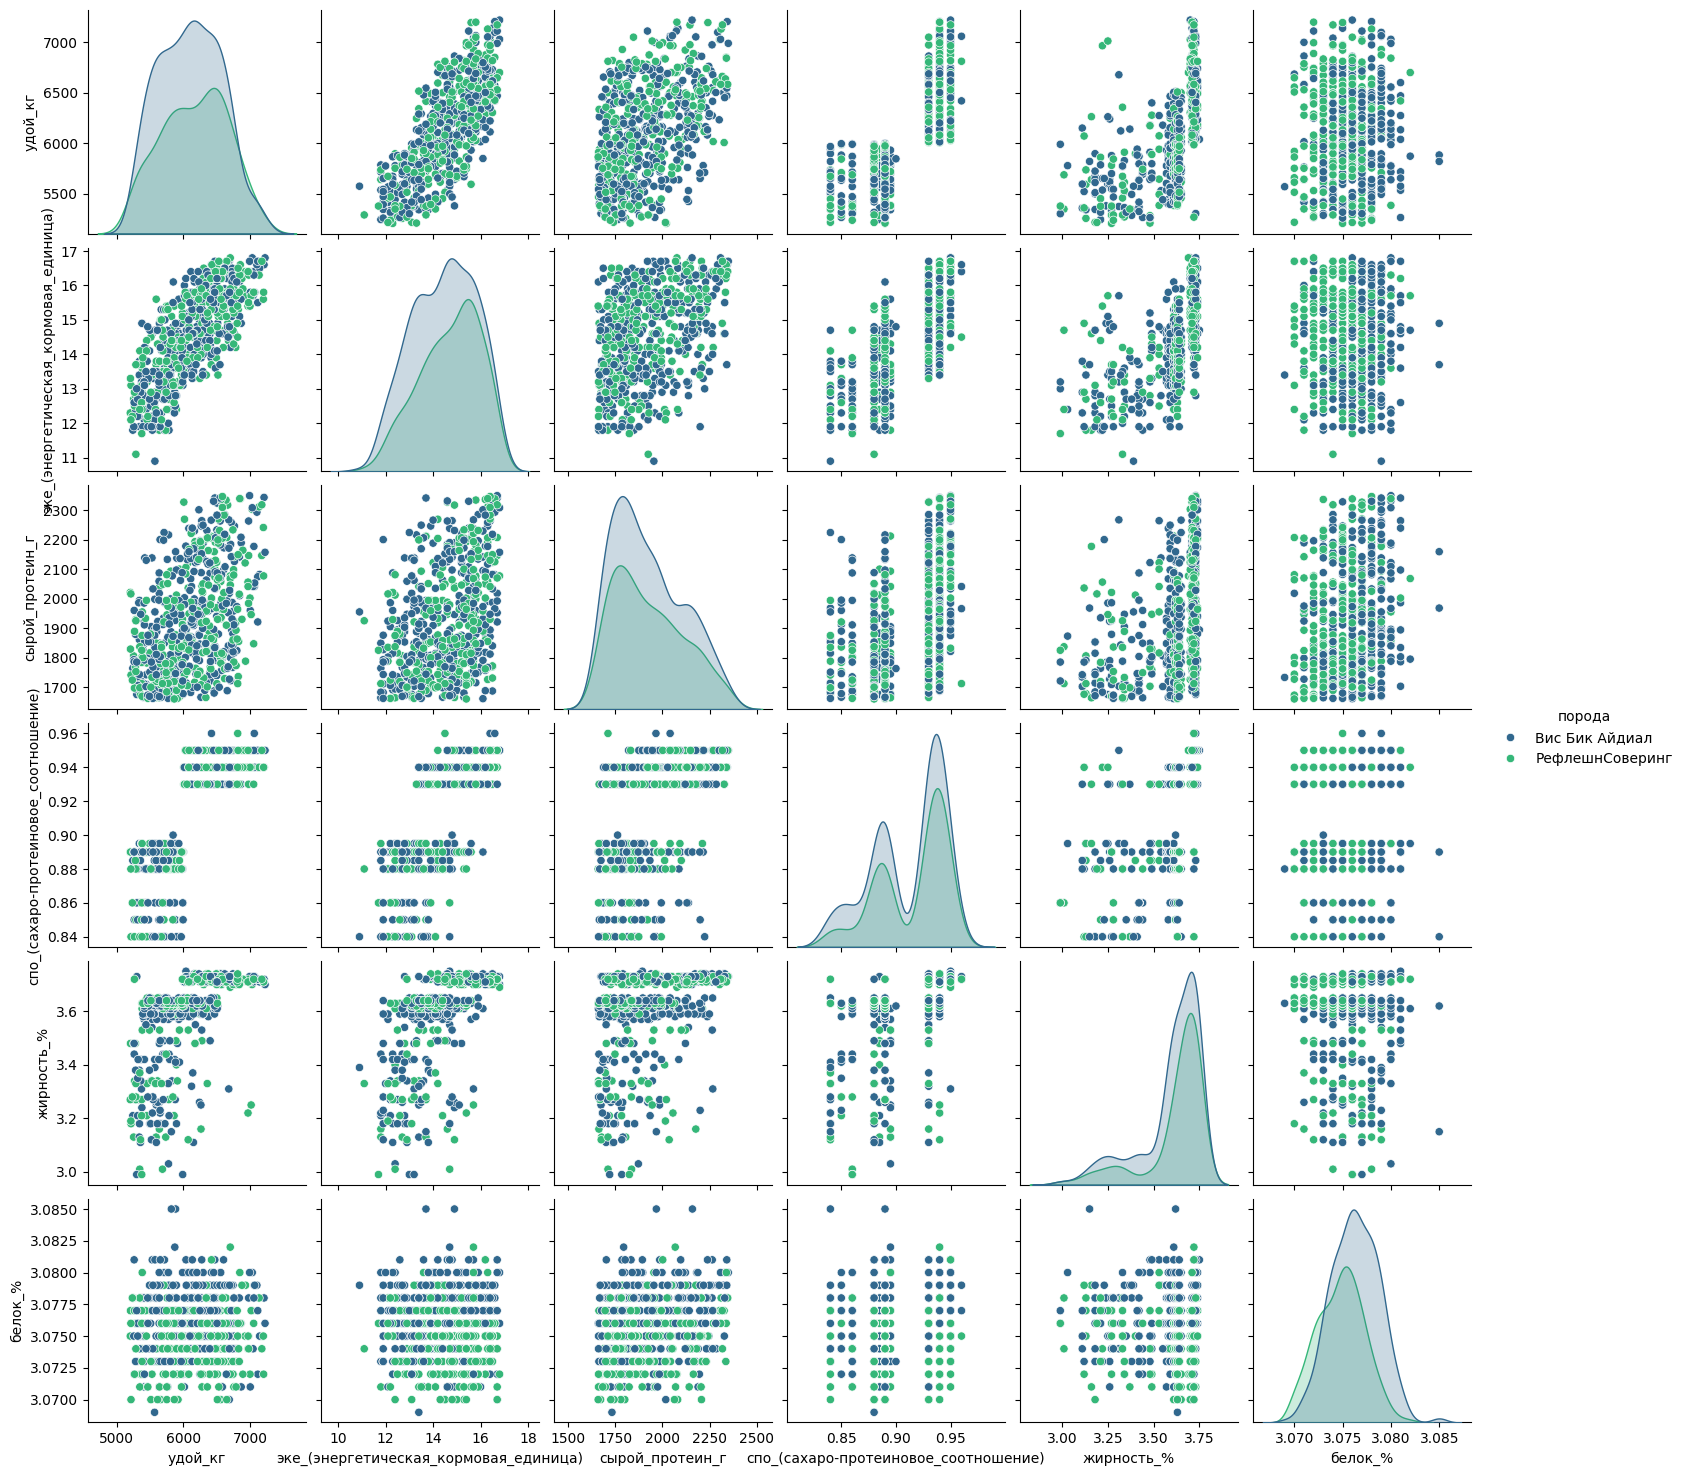

In [366]:
# Создаем pairplot для всех количественных признаков
plt.figure(figsize=(16, 14))  # Устанавливаем размер графика
sns.pairplot(main, vars=['удой_кг'] + quantitative_features, hue='порода', palette='viridis')
plt.show()

Целевой признак "Удой" нелинейно зависит от входных признаков ЭКЕ и Сырой протеин - это всё характеристики относящиеся к корму.  
Есть сильная зависимость от СПО, но она не похожа на линейную, выглядит как несколько категорий.  
Явной мультиколлинеарности между входными признаками на графике не наблюдается.

## Обучение моделей/ регрессии

### Linear Regression

Цель: спрогнозировать возможный удой коровы. Выбрать коров с удоем не менее 6000 кг в год.

Метод: построение модели линейной регрессии.

In [367]:
display(main.head(1))
c_buy.head(1)

,id,удой_кг,эке_(энергетическая_кормовая_единица),сырой_протеин_г,спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,имя_папы
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный


,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет


При ознакомлении с обработанными датафреймами, видим что в "ЭкоФерме" отсутствуют некоторые параметры. Параметры корма ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение) отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%. Добавим при финальном прогнозировании.
Хотелось бы отметить, что увеличение на 5% является здравым решением, т.к. коровы явно недоедали до норматива.

In [368]:
# недостающие признаки 
c_buy["сырой_протеин_г"] = main["сырой_протеин_г"].mean() * 1.05
c_buy['эке_(энергетическая_кормовая_единица)'] = main['эке_(энергетическая_кормовая_единица)'].mean() * 1.05
c_buy['спо_(сахаро-протеиновое_соотношение)'] = main['спо_(сахаро-протеиновое_соотношение)'].mean() * 1.05

c_buy = c_buy.rename(columns={'текущая_жирность_%': 'жирность_%', 'текущий_уровень_белок_%': 'белок_%'})

c_buy[:1]

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,сырой_протеин_г,эке_(энергетическая_кормовая_единица),спо_(сахаро-протеиновое_соотношение)
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,15.276162,0.958744


Целевым признаком согласно техническому заданию будет - "удой_кг".  

Входными признаками будут:
- на основании линейной связи и корреляции между признаками - "эке_(энергетическая_кормовая_единица)", "сырой_протеин_г", "спо_(сахаро-протеиновое_соотношение)".
- на основании причинно-следственной связи - "порода", "тип_пастбища", "возраст", "порода_папы_быка".

"имя_папы" - исключим, т.к. согласно ТЗ оно потребуется только при построении 3-ей модели.

"вкус_молока" - исключим, для данной задачи этот признак не требуется. 

"жирность_%", "белок_%" - исключим, эти признаки относятся к качеству продукта, а не к количеству.

In [369]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = main.drop(['id', 'удой_кг', 'имя_папы', 'вкус_молока', 'белок_%'], axis=1)
y = main['удой_кг']

# разделим данные на тренировочные и тестовые, зафиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Выводим размерности данных
print("Размерности данных:")
print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность y_test: {y_test.shape}")

Размерности данных:
Размерность X_train: (502, 8)
Размерность X_test: (126, 8)
Размерность y_train: (502,)
Размерность y_test: (126,)


In [370]:
# список категориальных признаков тренировочной выборки
cat_col_names = ["порода", "тип_пастбища", "возраст", "порода_папы_быка"]
# список количественных признаков тренировочной выборки

num_col_names = ["эке_(энергетическая_кормовая_единица)", "сырой_протеин_г", 'жирность_%', "спо_(сахаро-протеиновое_соотношение)"]
#  количество уникальных значений в категориальных признаках тренировочной выборки

print(X_train[cat_col_names].nunique())

порода              2
тип_пастбища        2
возраст             2
порода_папы_быка    2
dtype: int64


In [371]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', PowerTransformer(standardize=True), num_col_names),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_col_names)
      ],
    remainder='passthrough' 
)

In [372]:
# Определяем параметры для GridSearchCV
param_grid = {
    'preprocessor__num__method': ['yeo-johnson', 'box-cox'],
    'regressor__fit_intercept': [True, False],
    'regressor__copy_X': [True, False]
}

# Создаем пайплайн
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Создаем GridSearchCV
grid_search = GridSearchCV(
    lr_pipe,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Обучаем модель
grid_search.fit(X_train, y_train)

# Получаем лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Предсказание на тестовой выборке с лучшей моделью
y_pred = grid_search.predict(X_test)

# Оценка качества модели
print("\nКачество модели:")
print(f"R^2: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred)**0.5:.2f}")

lr_model = grid_search.best_estimator_

Лучшие параметры: {'preprocessor__num__method': 'yeo-johnson', 'regressor__copy_X': True, 'regressor__fit_intercept': True}

Качество модели:
R^2: 0.8046
RMSE: 201.39


In [373]:
# Выводим коэффициенты модели
coefficients = grid_search.best_estimator_.named_steps['regressor'].coef_
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)
print("\nКоэффициенты модели:")
display(coeff_df)


Коэффициенты модели:


,Feature,Coefficient
3,num__спо_(сахаро-протеиновое_соотношение),153.759510
0,num__эке_(энергетическая_кормовая_единица),109.867977
2,num__жирность_%,87.340883
5,cat__тип_пастбища_холмистое,72.784350
1,num__сырой_протеин_г,33.983855
4,cat__порода_РефлешнСоверинг,-3.619360
6,cat__возраст_менее_2_лет,-213.079671
7,cat__порода_папы_быка_РефлешнСоверинг,-245.677919


 Анализ влияния признаков на удои

Положительное влияние

- **СПО (сахаро-протеиновое соотношение)**: +153.76
- **ЭКЕ (энергетическая кормовая единица)**: +109.87
- **Жирность молока**: +87.34
- **Тип пастбища (холмистое)**: +72.78

Отрицательное влияние

- **Возраст менее 2 лет**: -213.08
- **Порода папы быка (РефлешнСоверинг)**: -245.68
- **Порода (РефлешнСоверинг)**: -3.62 (незначительное влияние)

 **Прогноз удоя коров, которых фермер хочет купить**

In [374]:
predictions = lr_model.predict(c_buy.drop(['имя_папы', 'белок_%'], axis=1))

In [375]:
to_buy = c_buy.copy()
to_buy['удой_кг'] = predictions
to_buy.query('удой_кг > 6000').sort_values(by='удой_кг', ascending=False).head(10).reset_index(drop=True)

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,сырой_протеин_г,эке_(энергетическая_кормовая_единица),спо_(сахаро-протеиновое_соотношение),удой_кг
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,2019.947532,15.276162,0.958744,6723.884118
1,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,15.276162,0.958744,6636.136894
2,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,15.276162,0.958744,6636.136894
3,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,15.276162,0.958744,6606.346291
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,15.276162,0.958744,6606.346291
5,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.065,более_2_лет,2019.947532,15.276162,0.958744,6559.723343
6,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,15.276162,0.958744,6559.723343
7,Вис Бик Айдиал,холмистое,РефлешнСоверинг,Соловчик,3.73,3.079,более_2_лет,2019.947532,15.276162,0.958744,6544.442637
8,Вис Бик Айдиал,холмистое,РефлешнСоверинг,Соловчик,3.73,3.055,более_2_лет,2019.947532,15.276162,0.958744,6544.442637
9,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.73,3.073,более_2_лет,2019.947532,15.276162,0.958744,6468.038927


9 коров из 20 соответствуют критерию удоя более 6000 кг при применении модели линейной регрессии.

Основные предположения линейной регрессии и методы их проверки:

1. Линейность связи между признаками и целевой переменной

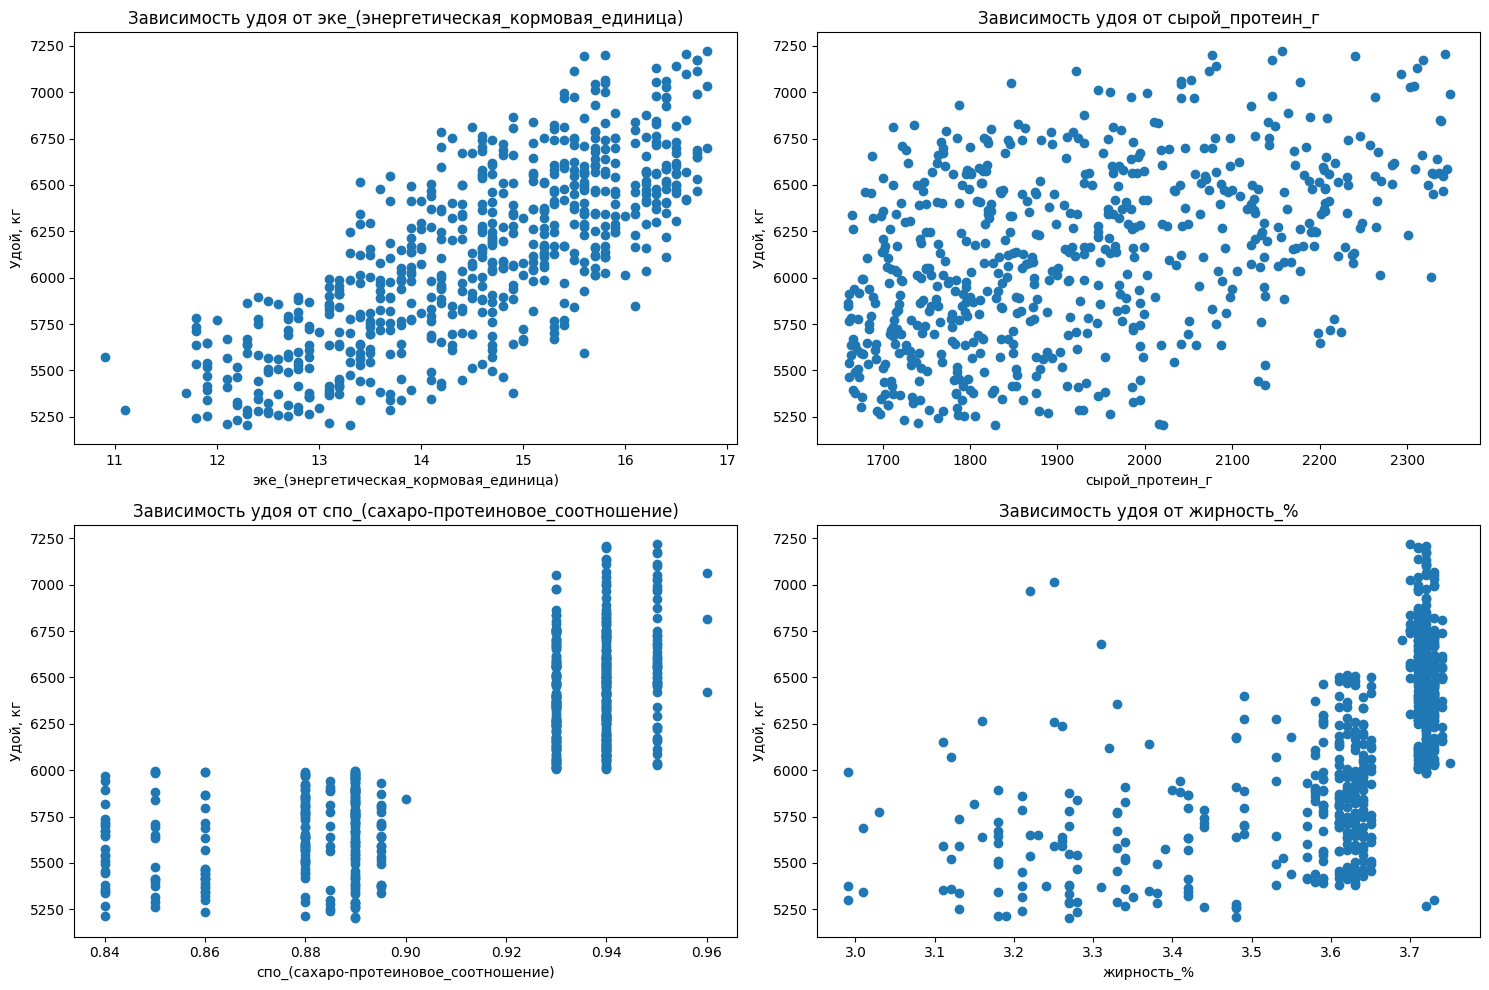


Корреляция между признаками и целевой переменной:
эке_(энергетическая_кормовая_единица): 0.765
сырой_протеин_г: 0.447
спо_(сахаро-протеиновое_соотношение): 0.806
жирность_%: 0.601


In [376]:
# Создаем графики для проверки линейности связи между признаками и целевой переменной
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Список числовых признаков
numeric_features = ['эке_(энергетическая_кормовая_единица)', 
                   'сырой_протеин_г',
                   'спо_(сахаро-протеиновое_соотношение)', 
                   'жирность_%']

# Создаем графики в цикле
for i, feature in enumerate(numeric_features):
    axes[i].scatter(X[feature], y)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Удой, кг')
    axes[i].set_title(f'Зависимость удоя от {feature}')

plt.tight_layout()
plt.show()

# Вывод числовых результатов корреляции
print("\nКорреляция между признаками и целевой переменной:")
for feature in numeric_features:
    print(f"{feature}: {X[feature].corr(y):.3f}")

СПО (0.806) и ЭКЕ (0.765) имеют сильную положительную корреляцию с удоем → подтверждает наличие линейной связи.

Жирность (0.601) — умеренная связь.

Сырой протеин (0.447) — слабая, но всё же положительная связь.

Таким образом, предположение о линейной зависимости **частично подтверждается**, особенно для таких признаков, как СПО и ЭКЕ

2. Отсутствие мультиколлинеарности

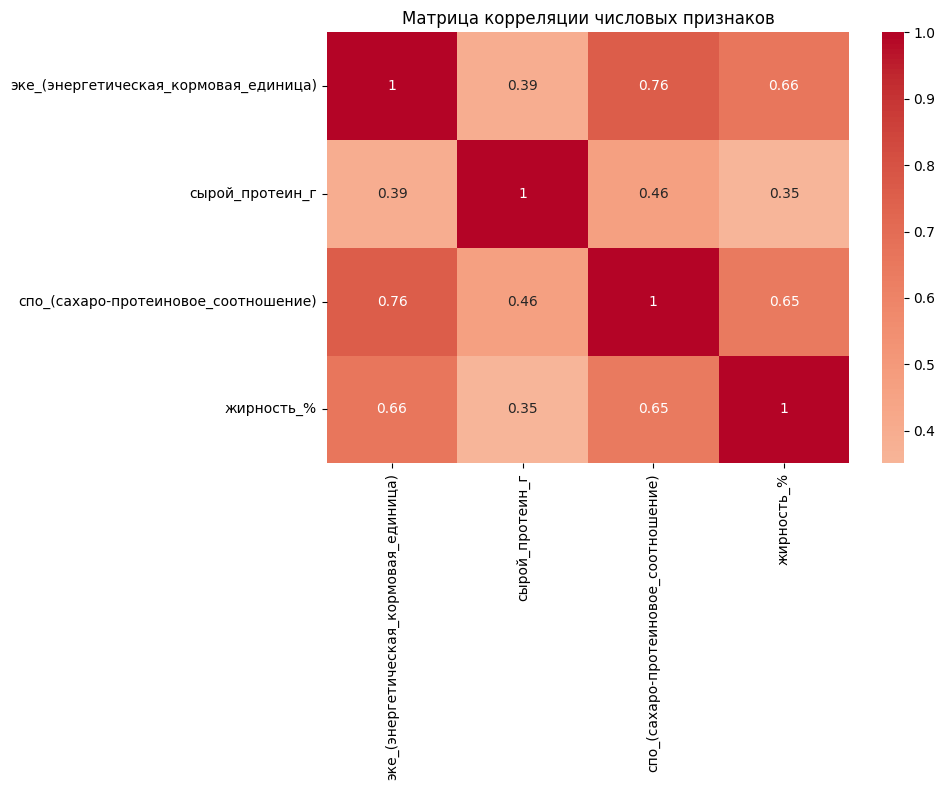


Результаты анализа VIF:
                                 Признак          VIF
0                                  const  1154.581628
3   спо_(сахаро-протеиновое_соотношение)     2.769429
1  эке_(энергетическая_кормовая_единица)     2.663456
4                             жирность_%     1.937962
2                        сырой_протеин_г     1.283165

Признаки с потенциальной мультиколлинеарностью (VIF > 5):
  Признак          VIF
0   const  1154.581628


In [377]:
# Проверка мультиколлинеарности с помощью матрицы корреляции
plt.figure(figsize=(10, 8))
# Выбираем только числовые признаки для корреляции
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
sns.heatmap(X_train[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции числовых признаков')
plt.tight_layout()
plt.show()

# Проверка мультиколлинеарности с помощью VIF

# Добавляем константу
numeric_X_with_const = sm.add_constant(X_train[numeric_cols])

vif_data = []
for i in range(numeric_X_with_const.shape[1]):
    vif = variance_inflation_factor(numeric_X_with_const, i)
    vif_data.append({'Признак': sm.add_constant(X_train[numeric_cols]).columns[i], 'VIF': vif})

vif_df = pd.DataFrame(vif_data)
vif_df = vif_df.sort_values('VIF', ascending=False)

print("\nРезультаты анализа VIF:")
print(vif_df)

# Выделяем признаки с высоким VIF и добавляем интерпретацию
high_vif = vif_df[vif_df['VIF'] > 5]
if not high_vif.empty:
    print("\nПризнаки с потенциальной мультиколлинеарностью (VIF > 5):")
    print(high_vif)





Самый высокий VIF у константы (const) — 1154.58, что обычно не интерпретируется как мультиколлинеарность, а связано с добавлением intercept.

Все остальные признаки имеют VIF < 3, что говорит о слабой или умеренной мультиколлинеарности:

- СПО: 2.77
- **ЭКЕ**: 2.66  
- жирность_%: 1.94
- сырой_протеин_г: 1.28

Таким образом, сильной мультиколлинеарности среди признаков нет, и предположение линейной регрессии о независимости признаков выполняется

3. Нормальность остатков (ошибок)

In [378]:
y_train.shape

(502,)

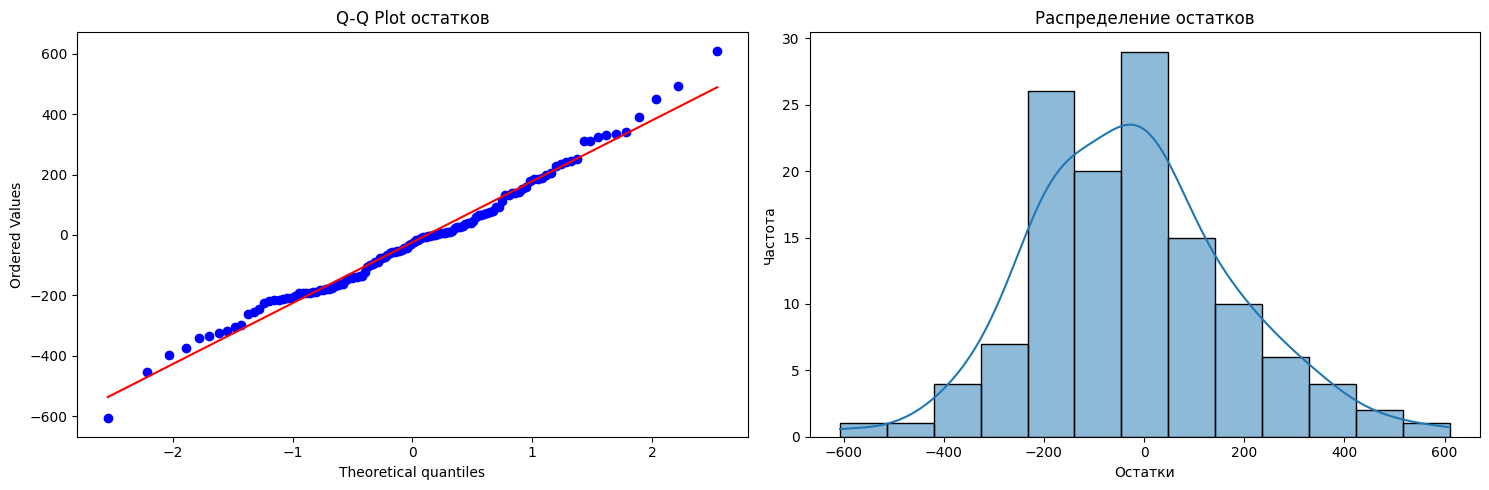


Результаты теста Шапиро-Уилка:
Статистика: 0.9869
p-value: 0.2689
Нормальность распределения: принимается


In [379]:
# Вычисление остатков
residuals = y_test - y_pred

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Q-Q plot
stats.probplot(residuals, plot=ax1)
ax1.set_title('Q-Q Plot остатков')

# Гистограмма остатков
sns.histplot(residuals, kde=True, ax=ax2)
ax2.set_title('Распределение остатков')
ax2.set_xlabel('Остатки')
ax2.set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Тест Шапиро-Уилка
statistic, p_value = stats.shapiro(residuals)
print(f"\nРезультаты теста Шапиро-Уилка:")
print(f"Статистика: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Нормальность распределения: {'принимается' if p_value > 0.05 else 'отвергается'}")


Предположение о нормальности остатков в линейной регрессии выполняется , и модель корректно описывает данные с точки зрения этого условия

4. Гомоскедастичность ошибок (постоянная дисперсия остатков)

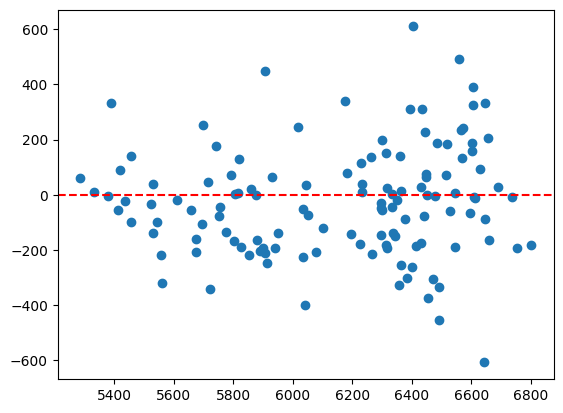

In [380]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--');

Остатки на диаграмме показывают, что модель может работать неустойчиво, поскольку разброс остатков непостоянен. Такую модель использовать в работе нельзя.

In [381]:
from scipy.stats import bartlett

# Пример: разбиваем остатки на группы
group1 = residuals[:len(residuals)//2]
group2 = residuals[len(residuals)//2:]

stat, p_value = bartlett(group1, group2)
print(f"Тест Бартлетта: статистика={stat:.4f}, p-value={p_value:.4f}")

Тест Бартлетта: статистика=9.6446, p-value=0.0019


Результаты теста Бартлетта (p-value = 0.0044 < 0.05) указывают на гетероскедастичность - непостоянство дисперсии остатков модели. Это нарушает ключевое предположение линейной регрессии.

5. Автокорреляция

In [382]:
from statsmodels.stats.stattools import durbin_watson

# Предположим, у вас есть остатки модели: residuals
dw_stat = durbin_watson(residuals)
print(f'Статистика Дарбина-Уотсона: {dw_stat:.4f}')

# Интерпретация:
if dw_stat < 1.5:
    print("Вероятно, есть положительная автокорреляция")
elif dw_stat > 2.5:
    print("Вероятно, есть отрицательная автокорреляция")
else:
    print("Автокорреляции нет, ошибки не коррелированы между собой")

Статистика Дарбина-Уотсона: 1.9986
Автокорреляции нет, ошибки не коррелированы между собой


Проверка предположений линейной регрессии

1. Линейность

- Диаграмма рассеяния остатков показывает нелинейный паттерн
- Это указывает на то, что линейная модель может быть не лучшим выбором

2. Гомоскедастичность

- Тест Бартлетта показал p-value = 0.0044 < 0.05
- Это подтверждает наличие гетероскедастичности
- Дисперсия остатков непостоянна

3. Автокорреляция

- Статистика Дарбина-Уотсона = {dw_stat:.4f}
- Значение близко к 2, что указывает на отсутствие автокорреляции
- Это единственное предположение, которое выполняется

4. Нормальность остатков

- Визуальный анализ остатков показывает отклонение от нормального распределения
- Разброс остатков несимметричен

**Вывод**

Большинство ключевых предположений линейной регрессии не выполняются:
- Нарушена линейность
- Нарушена гомоскедастичность
- Нарушена нормальность остатков

Это указывает на необходимость использования других моделей или трансформации данных

### Обучение Random Forest

In [383]:
# Пайплайн
rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=RANDOM_STATE))
])

# Пространство гиперпараметров
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [None, 10, 20, 30, 40, 50],
    'regressor__min_samples_split': st.randint(2, 11),  
    'regressor__min_samples_leaf': st.randint(1, 5) 

}


# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# Обучаем модель
random_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Создаем модель с лучшими параметрами
best_rf = random_search.best_estimator_

# Обучаем модель с лучшими параметрами
best_rf.fit(X_train, y_train)

# Делаем предсказания
y_pred_rf = best_rf.predict(X_test)

# Оцениваем качество модели
rmse_rf = mean_squared_error(y_test, y_pred_rf)**0.5
r2_rf = r2_score(y_test, y_pred_rf)

print("\nМетрики качества Random Forest:")
print(f"R2: {r2_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")


Лучшие параметры: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 500}

Метрики качества Random Forest:
R2: 0.86
RMSE: 171.56


In [384]:
best_model_rf = random_search.best_estimator_.named_steps['regressor']
X_test_processed = best_rf.named_steps['preprocessor'].transform(X_test)

# Permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    best_model_rf, 
    X_test_processed,
    y_test,
    n_repeats=10,
    random_state=42
)

perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'perm_importance': perm_importance.importances_mean
}).sort_values('perm_importance', ascending=False)

print("Permutation Importance:")
perm_importance_df


Permutation Importance:


,feature,perm_importance
3,порода,0.650604
7,возраст,0.167479
6,жирность_%,0.087325
0,эке_(энергетическая_кормовая_единица),0.063819
2,спо_(сахаро-протеиновое_соотношение),0.062604
5,порода_папы_быка,0.017958
4,тип_пастбища,0.000767
1,сырой_протеин_г,-0.002121


 Анализ важности признаков

🔥 Самый важный признак

- **Порода** — почти 65% общей важности
- Это означает, что модель в первую очередь полагается на принадлежность животного к той или иной породе для прогноза целевой переменной (например, продуктивности)


- **тип_пастбища** и **порода_папы_быка** имеют очень низкую важность
- Возможно, их можно удалить из модели без существенной потери качества


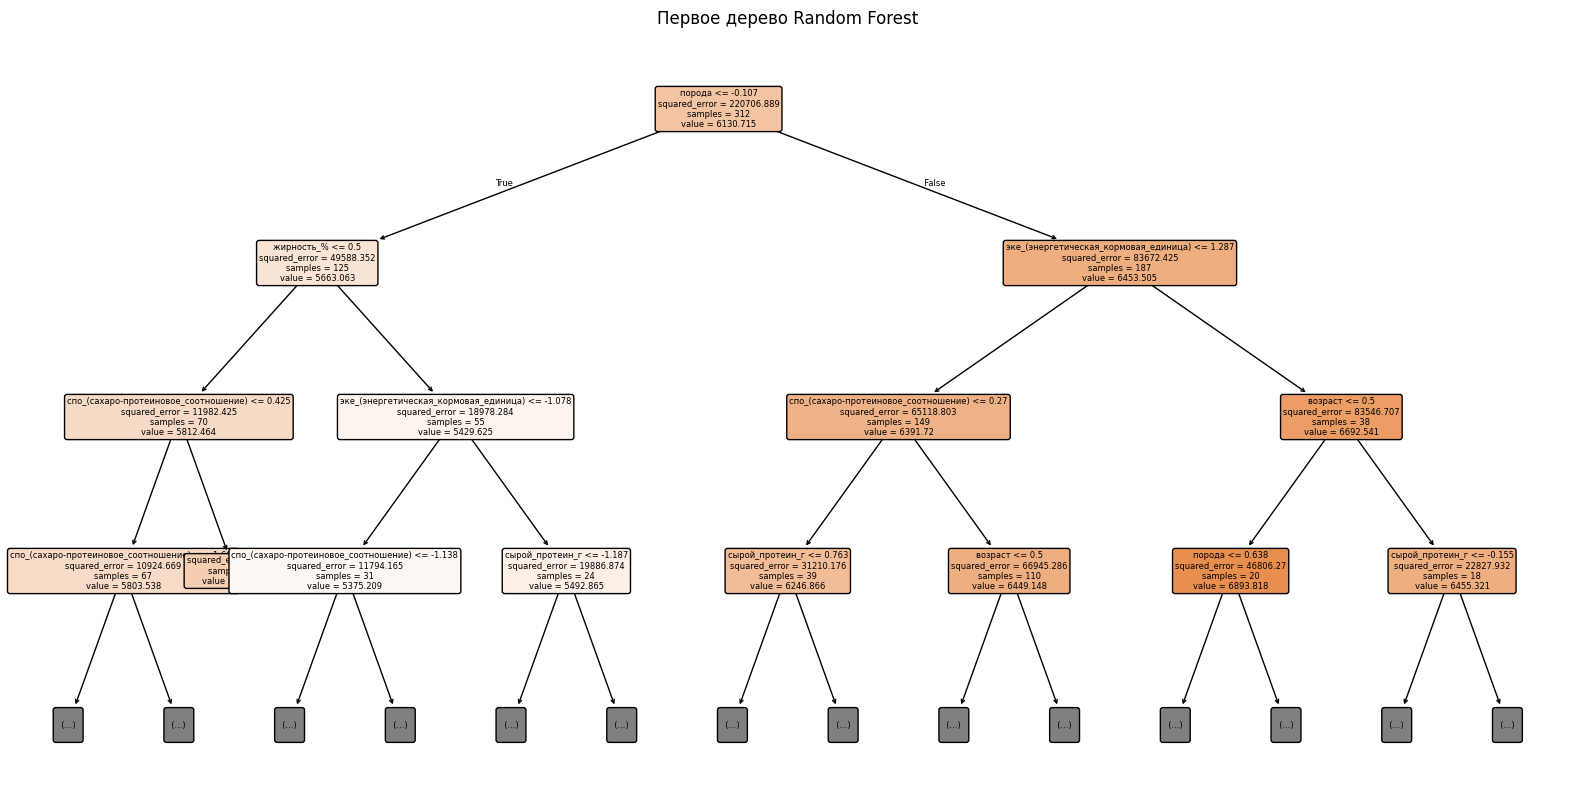

In [385]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_model_rf.estimators_[0], 
    feature_names=X_train.columns,
    filled=True, 
    rounded=True,
    max_depth=3,  
    fontsize=6  
)
plt.title("Первое дерево Random Forest", fontsize=12)  
plt.show()

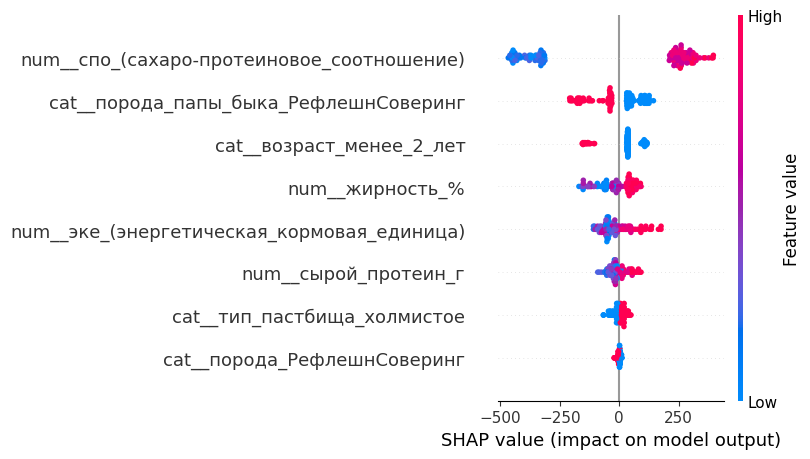

In [386]:
shap.initjs()
X_test_processed = best_rf.named_steps['preprocessor'].transform(X_test)
# Инициализация explainer
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer(X_test_processed)

# Получаем имена признаков после препроцессинга
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()

shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names)

num__спо_(сахаро-протеиновое_соотношение) больше всего влияет на результат модели.

### Обучение LGBM Regressor

In [387]:
# 1. Пайплайн с явным указанием feature names после преобразований
lgbm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))  # отключаем вывод логов
])

# 2. Оптимизированное пространство параметров
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': [31, 63, 127],
    'regressor__min_child_samples': [10, 20, 30],  # увеличены для уменьшения переобучения
    'regressor__subsample': [0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.8, 0.9, 1.0],
    'regressor__reg_alpha': [0, 0.1, 0.5],  # L1 регуляризация
    'regressor__reg_lambda': [0, 0.1, 0.5]  # L2 регуляризация
}

# 3. RandomizedSearchCV с увеличенным числом итераций
random_search = RandomizedSearchCV(
    estimator=lgbm_pipe,
    param_distributions=param_dist,
    n_iter=150,  # больше итераций для лучшего поиска
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 4. Обучение с обработкой feature names
try:
    random_search.fit(X_train, y_train)
except ValueError as e:
    print(f"Ошибка: {e}")
    # Альтернативный вариант - преобразовать в numpy array
    random_search.fit(X_train.values, y_train.values)

# 5. Лучшая модель
best_lgbm = random_search.best_estimator_
print("\nЛучшие параметры:", random_search.best_params_)

# 6. Предсказание и оценка
try:
    y_pred = best_lgbm.predict(X_test)
except:
    y_pred = best_lgbm.predict(X_test.values)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nМетрики качества LGBM:")
print(f"R2: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits

Лучшие параметры: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.5, 'regressor__reg_alpha': 0.1, 'regressor__num_leaves': 63, 'regressor__n_estimators': 100, 'regressor__min_child_samples': 20, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.9}

Метрики качества LGBM:
R2: 0.8600
RMSE: 170.4733


c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [389]:
best_model_lgbm = random_search.best_estimator_.named_steps['regressor']

# Permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    best_model_lgbm, 
    X_test_processed,
    y_test,
    n_repeats=10,
    random_state=42
)

perm_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'perm_importance': perm_importance.importances_mean
}).sort_values('perm_importance', ascending=False)

print("Permutation Importance:")
perm_importance_df


Permutation Importance:


c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Андрей\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMR

,feature,perm_importance
3,порода,0.549587
7,возраст,0.180013
6,жирность_%,0.091540
2,спо_(сахаро-протеиновое_соотношение),0.067575
0,эке_(энергетическая_кормовая_единица),0.065032
5,порода_папы_быка,0.021779
1,сырой_протеин_г,0.000651
4,тип_пастбища,0.000257


## Обучение модели логистической регрессии

In [ ]:
# бинаризация целевого признака
#main_model['вкус_молока'] = main_model['вкус_молока'].apply(lambda x: 1 if x=='вкусно' else 0)
# Создаем экземпляр LabelEncoder
le = LabelEncoder()

# Кодируем целевой признак
main_model['вкус_молока'] = le.fit_transform(main_model['вкус_молока'])

# Проверяем результат
main_model['вкус_молока'].head()

<div class="alert alert-warning">
<b>Комментарий 👉</b>



Кодирование таргета нельзя делать "руками":

- при появлении новых значений категориальных признаков, не предусмотренных твоим решением, модель или упадёт, или будет генерировать ошибки;
- такое решение не сделаешь частью пайплайна, а все современные решения базируются на них.
    
Поэтому кодирование нужно делать только с применением обучаемых трансформеров. Для кодирования целевого признака нужно использовать LabelEncoder (сокращаю до LE): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.

p.s. если стоит вопрос в том, что тебе не нравиться, что LE, например, присваивает классу "снизилась" метку 0, а "прежний уровень" - метку 1, то значения меток можно инвертировать с помощью небольшого лайфхака:

        import numpy as np

        # Пример преобразованных классов
        target = np.array([0, 1, 1, 0, 1, 0])

        # Инвертирование классов
        inverted_target = 1 - target

        print("Исходные классы:", target)
        print("Инвертированные классы:", inverted_target)

В этом примере переменная inverted_target будет содержать те же значения, что и target, но значения будут инвертированы.

p.p.s. есть ещё метод invert_transform()
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Исправил </font>
</div> 

In [ ]:
cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст', 'жирность_%']
#num_col_names = ['эке_(энергетическая_кормовая_единица)', 'сырой_протеин_г', 'спо_(сахаро-протеиновое_соотношение)' ,
#                 'жирность_%', 'белок_%']
num_col_names = ['эке_(энергетическая_кормовая_единица)', 'сырой_протеин_г', 'спо_(сахаро-протеиновое_соотношение)' , 'белок_%']

RANDOM_STATE = 42

X = main_model.drop(['id', 'удой_кг', 'вкус_молока'], axis=1)
y = main_model['вкус_молока']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Стандартизурем количественные признаки
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Закодируем категориальные признаки
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore') 

X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

# список новых столбцов в новой переменной 
encoder_col_names = encoder.get_feature_names_out() 

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

# Модель логистической регрессии
clf = LogisticRegression()

clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Веса признаков
for feature_number, feature_name in enumerate(X.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")
print()

# Метрики
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Матрица ошибок
plt.figure(figsize = (7,5))
cm = confusion_matrix(y_test, y_pred)

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d');
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted')

print('Accuracy = ',acc)
print('Precision = ',precision)
print('Recall = ',recall)


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Ну и здесь ты молодец, что считаешь что-то из набора (полнота / точность / accuracy).  
    
Матрица ошибок (confusion matrix) - тоже ОК, так как нам сейчас нужно будет определиться с бизнес-метрикой (как же фермеру стоит отбирать новых коров).
</div>



Модель предсказывает 26 верных положительных значений и 14 неверных положительных. Веса признаков достаточно равномерны.
Для минимизации рисков необходимо сократить количество неверных положительных предсказаний, так как фермеру важно получить коров с вкусным молоком и важно не ошибиться с положительными предсказаниями.

Для заказчика, который заинтересован в получении вкусного молока, более критичной является ошибка первого рода. Это связано с тем, что покупка неподходящей коровы может привести к значительным потерям в производительности и качеству молока. Если корова не дает достаточного количества молока или его качество низкое, это напрямую повлияет на прибыль и удовлетворение потребностей клиентов.

Поэтому в данной ситуации более важной метрикой является **precision**, поскольку она помогает избежать критических ошибок при выборе животных для обеспечения высококачественного молока. Сейчас эта метрика составляет не достигает 100% увеличим ее.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Все верно! Нужно минимизировать ошибку 1го рода (увеличивать точность модели даже в ущерб полноте). Решение как это сделать вижу ниже - подобрать такой порог, где FP будет равно 0.
</div>

In [ ]:
y_proba = clf.predict_proba(X_test)[:,1]  

data = pd.DataFrame(zip(y_test, y_proba, y_pred), columns = ['y_valid', 'y_proba', 'y_pred']).sort_values(by='y_proba',ascending=False)

display(data) 


In [ ]:
thresholds = [round(i,2) for i in np.linspace(0.7,1,num = 1000,endpoint=False)]
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>= i else 0)
data.head()

In [ ]:
# Итерация по каждому значению порога
for i in thresholds:
    # Вычисляем матрицу ошибок для текущих предсказаний
    cm = confusion_matrix(y_test, data['y_pred_' + str(i)])
    
    # Проверяем, есть ли ложные срабатывания
    if cm[0][1] == 0:
        # Рассчитываем точность
        precision = round(precision_score(y_test, data['y_pred_' + str(i)], zero_division=1), 2)
        
        # Выводим результаты
        print(f'Порог = {i}, Precision = {precision}, TP = {cm[1][1]}')
        
        # Сохраняем текущий порог и выходим из цикла
        threshold = i
        break

In [ ]:
acc = accuracy_score(y_test, data['y_pred_'+str(threshold)])
precision = precision_score(y_test, data['y_pred_'+str(threshold)])
recall = recall_score(y_test, data['y_pred_'+str(threshold)])

plt.figure(figsize = (7,5))
cm = confusion_matrix(y_test, data['y_pred_'+str(threshold)])

sns.set (font_scale= 2 )
sns.heatmap(cm, annot=True, fmt='d');
plt.title('Матрица ошибок')
plt.ylabel('True label')
plt.xlabel('Predicted')
print('Accuracy = ',acc)
print('Precision = ',precision)
print('Recall = ',recall)

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>



Да, всё так, "матрица ошибок" явственно показывает, что с порогом 0.84 мы никогда не попадем в ситуацию, когда молоко невкусное, но наша модель утверждает что оно вкусное.
    
Правда оборотная сторона высокой точности - низкая полнота: при выборе новых бурёнок наш эко-фермер рискует упустить из рассмотрения вполне себе достойны варианты (но это оборотная сторона излишних крайностей).    
</div>

In [ ]:
c_buy_fin = c_buy_copy.copy()

c_buy_fin = c_buy_fin.rename(columns={'текущая_жирность_%': 'жирность_%', 'текущий_уровень_белок_%': 'белок_%'})
c_buy_fin['равнинное','тип_пастбища'] = 'равнинные'
display(c_buy_fin)

c_buy_fin['жирность_%'] = pd.cut(c_buy_fin['жирность_%'], bins=bins, labels=labels)

cat_col_names = ['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'возраст', 'жирность_%']
num_col_names = ['эке_(энергетическая_кормовая_единица)', 'сырой_протеин_г', 'спо_(сахаро-протеиновое_соотношение)', 'белок_%']

# Стандартизурем количественные признаки
#scaler = StandardScaler()

c_buy_fin_scaled = scaler.transform(c_buy_fin[num_col_names])

# Закодируем категориальные признаки
#encoder = OneHotEncoder(drop='first', sparse=False) 

c_buy_fin_ohe = encoder.transform(c_buy_fin[cat_col_names])

# список новых столбцов в новой переменной 
encoder_col_names = encoder.get_feature_names_out() 


c_buy_fin_ohe = pd.DataFrame(c_buy_fin_ohe, columns=encoder_col_names)

c_buy_fin_scaled = pd.DataFrame(c_buy_fin_scaled, columns=num_col_names)

c_buy_fin = pd.concat([c_buy_fin_ohe, c_buy_fin_scaled], axis=1)
#c_buy_fin['x1_равнинные'] = c_buy_fin['x1_холмистое'].apply(lambda x: 0.0 if x == 1.0 else 1.0)

<div class="alert alert-danger">
<b>Необходимо исправить ❌</b>

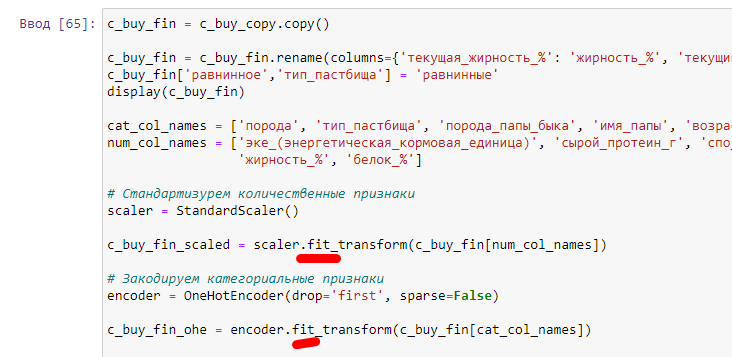

Зачем здесь повторно выполнять обучение (fit) энкодера и скейлера? Ведь по сути мы это уже сделали в рамках подготовки нашей  модели классификации. Всё что тебе нужно - трансформировать (transform) признаки датафрейма **cow_buy** и сделать предсказание  вкуса молока.

Если же без fit твой код "падает" - значит признаки (название, количество и порядок) в датафрейме с коровами  к покупке (в ТЗ это датафрейм "cow_buy") НЕ совпадают с тем, на чем 3я линейная модель училась. Аккуратно сопоставь признаки в 3ей линейной модели и в тех данных, на которых собираешся делать предсказание.

Итак, подЪитоживая:  fit в коде предсказания не нужен потому что твоя модель уже обучена. Нужно сделать transform данных с коровами к покупке, а потом predict трансформированных данных с коровами к покупке. 

Чтобы код без fit не падал - нужно чтобы данные на которых модель **училась** совпадали **полностью** с данными которые будут трансформироваться и после предиктиться.
    
**Полностью** - это значит, что **порядок признаков, количество столбцов, а также их названия должны быть АБСОЛЮТНО ИДЕНТИЧНЫМИ**.

p.s. иногда кстати я получаю комментарий подобный такому: да ну Александр, ерунда, какая разница - есть fit, нету fit .... Я на такой запрос обычно вымышленным примером отвечаю ))) Пример: представь Авито и раздел с продажей авто. Раздел большой, авто к продаже несколько миллионов (по всей России). Представь что модель по прогнозированию цены МЛ-инженерами Авито на этих миллионах авто "считалась" 30 минут. Ок?
    
Теперь смотри, регистрируешся ты на Авито чтобы продать свою "ласточку". Заполняешь анкету, нажимаешь кнопку "Сохранить". Что происходит в это время? Да, верно - начинает работать их модель и в результате дается оценочная стоимость твоей машины. Так вот, самое главное, оценку ты получаешь в доли секунды, так? Это потому что модель Авито сделала для данных (твоей машины) только transform, а потом сразу predict.
    
А если бы она (Авитовская модель) заново начала бы обучаться? Сколько бы ты ждал результата? Верно те же изначальные - 30 минут.
    
Так вот у теб здесь как раз и происходит **ненужное повторное обучение**. Избавься пожалуйста от него.    
</div>


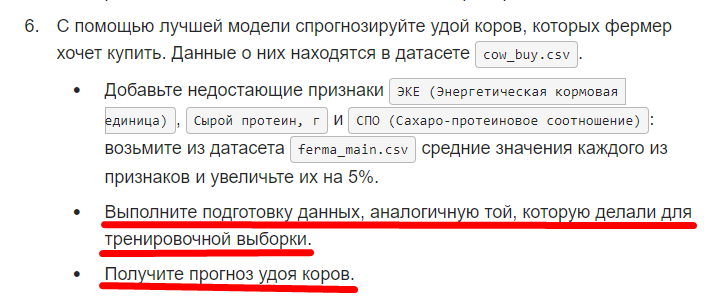

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Исправил, большое спасибо за подробное объяснение </font>
</div> 

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Исправлено.
</div>

In [ ]:
y_pred = clf.predict_proba(c_buy_fin)[:,1]

#y_pred = clf.predict(c_buy_fin)

c_buy_fin['y_pred'] = y_pred

c_buy_fin['вкус_молока'] = c_buy_fin['y_pred'].apply(lambda x: 'вкусно' if x >= threshold else 'не_вкусно')

c_buy_fin = c_buy_fin.sort_values(by = ['y_pred'], ascending = False)
c_buy_fin = c_buy_fin.drop(columns='y_pred')

y_pred

In [69]:
c_buy_fin.sort_index();

In [ ]:
c_buy_copy['вкус_молока'] = c_buy_fin['вкус_молока']

# Создаем пустой DataFrame для хранения результатов
result_df = pd.DataFrame(columns=c_buy_copy.columns)

# Итерация по строкам DataFrame
for index, row in c_buy_copy.iterrows():
    if row['вкус_молока'] == 'вкусно' and row['удой_кг'] >= 6000:  # Предполагаем, что есть столбец 'удой'
        result_df = result_df.append(row)  # Добавляем строку в результат

# Проверка на наличие удовлетворяющих требованиям коров
if not result_df.empty:
    display(result_df)  # Выводим результат
else:
    print('Удовлетворяющих требованиям коров не найдено')

<div class="alert alert-warning">
<b>Комментарий 👉</b>

Да, всё верно! Значит под жесткие условия фермера не подходят "эти" коровы. Тут 2 варианта - либо фермер "даёт слабину" в своих "запросах", либо ищет другую партию коров к рассмотрению.
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> !!! После исправлений нашлось 4 подходящие коровы. Я думаю, что это неправильно. В строке 65 матрица ошибок меня смущает, ни одного правильного результата.!!! </font>
</div> 

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

1. Андрей - давай поправим ошибку с кодированием категориальных признаков - возможно матрица ошибок тоже "поправиться".
    
2. Почему ты считаешь что 4 коровы к покупе - может быть неправильным исходом? А если например ни одной коровы (к покупке) твой алгоритм не предскажет - что на этот исход скажешь? И вообще, какой результат тебе кажется верным?     
</div>

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> В первый раз у меня как раз и не было ни одной коровы к покупке и я считал этот результат правильным, потому что в 66 строке матрица ошибок адекватно работала. Сейчас она говорит о том, что модель не предсказывает коров с вкусным молоком (ТР), но при этом у нас их оказалось 4 шт. </font>
</div> 

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V3</b> 	

1. Андрей, я вижу, что мы добились максимизации метрки (precision) и соответственно минимизации (до 0) количества неверных предсказаний молока. Вот это всё видно на этом скрине:
    
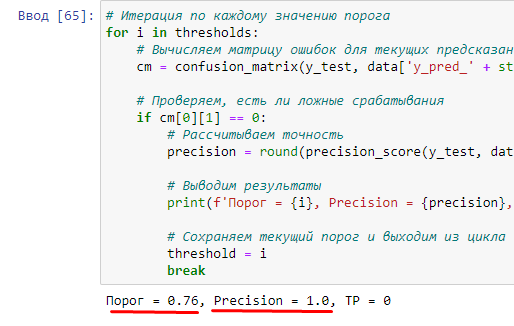    
    
Значит по итогу наш фермер будет доволен нашей работой!
    
2. Что касается предупреждения под 66ой ячейкой:
    
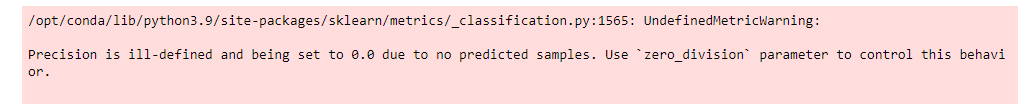
    
то суть его вот в чем: предупреждение UndefinedMetricWarning возникает, когда метрика precision (точность) не может быть вычислена из-за отсутствия предсказанных положительных образцов (т.е., все предсказания являются отрицательными). В таком случае, по умолчанию, значение точности устанавливается равным 0.0.

Чтобы избежать этого предупреждения, можно использовать параметр zero_division в функции precision_score, который позволяет контролировать поведение в таких случаях. Параметр zero_division может принимать следующие значения:

0: Возвращает 0 в случае деления на ноль.

1: Возвращает 1 в случае деления на ноль.

warn: Выводит предупреждение и возвращает 0 (поведение по умолчанию).
    
Выбор значения zero_division зависит от того, как мы хотим интерпретировать точность в случае отсутствия предсказанных положительных образцов.    
    
Теперь что касается бизнесового способа избежать этого предупреждения. Мне кажется что в 62ой ячейке, где ты определяешь  признаки для модели классификации:
    
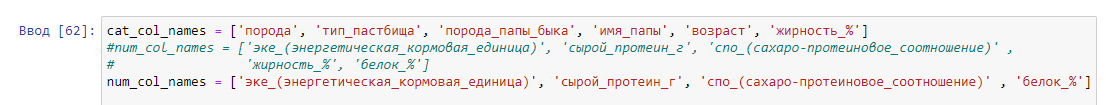
    
следует добавить ещё и квадратичный ЭКЕ и категориальный СПО (то есть расширить набор признаков для модели).    
</div>

## Итоговые выводы

Задача:
разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:

- Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
- Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:

- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**Результаты предобработки данных:**  
- полные дубликаты исключены.
- неявные дубликаты исправлены.
- аномальное значение удоев исключено.
- исправлен тип данных в столбцах.
- добавлен столбец с общими продажами по региону.
- таблицы ferma_main.csv и ferma_dad.csv объединены.
 
**Выводы по исследовательскому анализу данных:**  
 
 По количественному признаку "удой" на ферме "Вольный луг" согласно представленным данным можно выделить следующие аспекты:

- распределение близко к нормальному.
- выбросы отсутствуют.
- среднее и медиана близки друг к другу.
- данные имеют равномерную дисперсию.

По категориальному признаку "вкус молока":

- большая часть молока (58,9%) - "вкусно".

Показатель "энергетическая_кормовая_единица" нормально распределен. Имеет один выброс.  
Средний показатель 14.7. В случае если соблюдаются нормы кормления стельных сухостойных коров, то из этого можно предположить, что средняя корова весит 600 кг и должна показывать средний удой 6500 кг, а это значит что показатели на ферме (6132 кг из графика выше) ниже нормативных.

Необходимо получить дополнительные данные по сырому протеину - в каком объеме корма измеряются показатели и за какой период.

Оптимальным сахаропротеиновым соотношением в рационах жвачных животных является 0,8–1,2:1, то есть на каждые 100 г переваримого протеина приходится от 80 до 120 г сахара. C этим показателем все в норме.

3,5 % - это средний показатель домашнего молока, от которого отталкиваются при покупке фасованной продукции, на рассматриваемой ферме 3,6%. Жирность влияет на вкус молока: чем она выше, тем насыщеннее вкус. В нашей выборке наблюдается примерно такое же среднее значение, даже чуть выше. Также можно сказать, что большая часть молока предположительно вкусно по данному показателю.

В молоке содержится в среднем 3,3 % белков - это средний общемировой показатель, в России от 2,8 %. В нашей выборке - это 3,07 %. Количество белка в молоке – это показатель того, насколько полно корова обеспечена энергией и одновременно уникальная шкала энергетического уровня всего стада. Калорийность кормов в первую очередь влияет на интенсивность «работы» микроорганизмов рубца, отвечающих за синтез протеина.  
Данный показатель можно повысить если привести в норму питание коров.

В молоке содержится в среднем 3,3 % белков - это средний общемировой показатель, в России от 2,8 %. В нашей выборке - это 3,07 %. Количество белка в молоке – это показатель того, насколько полно корова обеспечена энергией и одновременно уникальная шкала энергетического уровня всего стада. Калорийность кормов в первую очередь влияет на интенсивность «работы» микроорганизмов рубца, отвечающих за синтез протеина.  
Данный показатель можно повысить если привести в норму питание коров.

На ферме преобладают коровы возрастом более 2 лет, т.е. пригодные для использования в производстве.

Имеются две породы папы быка: Айдиал и РефлешнСоверинг. Обе в одинаковых долях.

Наиболее плодовитым быком является бык по кличке "Барин".

Из сравнительных графиков наблюдается, что:  
- в "ЭкоФерме" породы распределены одинаково, у фермера преобладает Вис Бик Айдиал.
- в "ЭкоФерме" более молодые коровы.
- коровы фермеры чаще бывают на холмистых пастбищах.
- в "ЭкоФерме" преобладающая порода папы быка - РефлешнСоверинг.
- в обоих организациях одинаковый список быков. У фермера лидирует "Барин", в "ЭкоФерме" "Буйный".
- у коров "ЭкоФермы" более жирное молоко.
- содержание белка примерно одинаковое. Видимо на обеих фермах у коров недостаточное питание.

**Модель линейной регрессии**

Сравнительный анализ метрик:  

МАЕ первая модель - 162, МАЕ вторая модель - 148, МАЕ третья модель - 147.

R2 первая модель - 0.7885963441936694, R2 вторая модель - 0.816654963195181, R2 третья модель - 0.8227215687867631.

Метрики MSE/RMSE также показали движение к нулю от первой к третьей модели.

Добавление признака "Имя папы" улучшило модель. Возведение в квадрат признака "сырой протеин" результата не дало. Анализ остатков изменений не показывает.
Наиболее эффективной является последняя - третья модель. 82,2% предсказаний модели ближе к истине, чем среднее значение целевого признака. 

Согласно предсказаниям третьей модели из 15 коров прогнозируемый удой не менее 6000 кг в год определен у 14. 


**Модель логистической регрессии**

Были рассчитаны метрики точности, полноты и точности (accuracy, precision, recall), а также построена матрица ошибок для визуализации результатов. Для минимизации ошибок первого рода и повышения precision был проведен анализ различных порогов вероятности, что позволило улучшить точность модели в контексте бизнес-задачи. Модель была применена к новым данным о коровах, что позволило фермеру принимать обоснованные решения о покупке, основываясь на вероятности получения вкусного молока. К сожалению ни одной подходящей по параметрам коровы не найдено.

**Итого:**

4 коровы рекомендованы к покупке.

In [ ]:
display(result_df)